In [1]:
# This python notebook is used to build a QA LSTm for answering given questions
# Implements from: https://arxiv.org/pdf/1511.04108.pdf
# 
# 
# Author - Karthik D

%matplotlib inline
import os
import hiddenlayer as hl
import xml.etree.ElementTree as ET 
import json
import re
from tqdm import tqdm
from collections import Iterable
import random
import itertools
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

# Define Hyper-params

In [2]:
PAD = '<PAD>'
hidden_size = 60
seq_len = 5
batch_size = 64
n_epochs = 10
margin=1
max_sent_len = 50
embd_size = 300
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Util Functions

In [3]:
# Function to parse xml files
def parse_xml(datapath = "./Data/"):
    question_list = []
    k = 0
    for filename in os.listdir(datapath):
        if not filename.endswith('.xml'): continue
        k+=1
        fullname = os.path.join(datapath, filename)
        root = ET.parse(fullname).getroot()
        questDict = dict({root[0].tag:root[0].text})
        questDict['QID'] = k
        i=0
        for refAnswer in root[1]:
            i+=1
            refAnswerTag = "correct" + str(i)
            questDict[refAnswerTag] = refAnswer.text
        for studentAnswer in root[2]:
            i+=1
            studentAnswerTag = studentAnswer.attrib.get("accuracy") + str(i)
            questDict[studentAnswerTag] = studentAnswer.text
        #question_list.append(json.dumps(questDict))
        question_list.append(questDict)
    return(question_list)

# Parse the dictionary and convert to list   
def parse_dict(qa_dict):
    negs = []
    pos = []
    final = []
    qid = qa_dict.get('QID')
    q = list(filter(None, re.sub(r'[?/\(\)\.\,\[\]\{\}\!;:\"\']', " ", qa_dict.get('questionText')).lower().split(" ")))
    for key in qa_dict.keys():
        # Fetch the negatives
        if(bool(re.search(r'incorrect', key))):
            negs.append(list(filter(None, re.sub(r'[?/\(\)\.\,\[\]\{\}\!;:\"\']', " ", qa_dict.get(key)).lower().split(" "))))
            continue
        # Fetch the positives
        elif(key != 'questionText' and key != 'QID'):
            pos.append(list(filter(None, re.sub(r'[?/\(\)\.\,\[\]\{\}\!;:\"\']', " ", qa_dict.get(key)).lower().split(" "))))
    for correct in pos:
        final.append([qid, q, correct, negs])
    return(final)

# Wrapper function to make development data
def make_dev_data():
    questList = parse_xml()
    final = []
    for qa in questList:
        qs = parse_dict(qa)
        for q in qs:
            final.append(q)
    return final

# Function to flatten a list of lists
def flat_list_l1(qa_list):
    l = [word for sublist in qa_list for item in sublist for word in item]
    flat_l = []
    for i in l:
        if isinstance(i, Iterable) and not isinstance(i, str):
            for word in i:
                flat_l.append(word)
        else:
            flat_l.append(i)
    return list(filter(None, flat_l))

# Function to flatten a list of lists
def flat_list_l2(l1_flat):
    flat_l = []
    for i in l1_flat:
        if isinstance(i, Iterable) and not isinstance(i, str):
            for word in i:
                flat_l.append(word)
        else:
            flat_l.append(i)
    return list(filter(None, flat_l))

# Function to make vocabulary from list of words
def make_vocab(flattened_list) :
    vocab = [] 
    for word in flattened_list:
        if not word in vocab:
            vocab.append(word)
    return vocab

# Make the dict wort to index
def make_w2i(qa_list):
    vocab = make_vocab(flat_list_l2(flat_list_l1(qa_list)))
    w2i = {} 
    i = 0
    for word in vocab:
        if not word in w2i:
            w2i[word] = i
            i += 1
    return w2i, vocab

# Function to make train-test set
def make_train_test_set(qa_list, perc=0.8):
    ids =[]
    reminder = []
    train_list = []
    for qa in qa_list:
        idt = qa[0]
        if idt not in ids:
            train_list.append([qa[1], qa[2], qa[3]])
            ids.append(idt)
        else:
            reminder.append([qa[1], qa[2], qa[3]])
    train_set, test_set = train_test_split(reminder, perc)
    train_set.append(train_list)
    return train_set, test_set
        
# Function to make train-test split
def train_test_split(qa_list, perc=0.8):
    train_count = int(round(perc * len(qa_list), 0))
    train_idx = random.sample(range(len(qa_list)), k=train_count)
    test_idx = list(set(range(len(qa_list))) - set(train_idx))
    train = [qa_list[i] for i in train_idx]
    test = [qa_list[i] for i in test_idx]
    return train, test

# Wrapper function to make a torch variable
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Function to make word padding
def padding(data, max_sent_len, pad_token):
    pad_len = max(0, max_sent_len - len(data))
    data += [pad_token] * pad_len
    data = data[:max_sent_len]
    return data

# Wrapper to make a torch tensor from a list/np
def make_tensor(data, w2i, seq_len):
    ret_data = [padding([w2i[w] for w in d], seq_len, w2i[PAD]) for d in data]
    return to_var(torch.LongTensor(ret_data))

# QA_LSTM - **Define Model Architecture**

In [4]:
class WordEmbedding(nn.Module):
    def __init__(self, embed, vocab_sz, emb_sz, fine_tune=True):
        super(WordEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, emb_sz)
         # In QA-LSTM model, embedding weights are fine-tuned
        self.embedding.weight = nn.Parameter(embed, requires_grad=fine_tune)

    def forward(self, x):
        return self.embedding(x)


class QA_LSTM(nn.Module):
    def __init__(self, embed, vocab_sz, emb_sz, hidden_sz=hidden_size):
        super(QA_LSTM, self).__init__()
        self.hidden_sz, self.vocab_sz, self.emb_sz = hidden_sz, vocab_sz, emb_sz
        self.word_embd = WordEmbedding(embed, vocab_sz, emb_sz)
        self.shared_lstm = nn.LSTM(emb_sz, hidden_sz, batch_first=True, bidirectional=True)
        self.cos = nn.CosineSimilarity(dim=1)

    def forward(self, q, a):
        # embedding
        q = self.word_embd(q) # (bs, L, E)
        a = self.word_embd(a) # (bs, L, E)

        # LSTM
        q, _h = self.shared_lstm(q) # (bs, L, 2H)
        a, _h = self.shared_lstm(a) # (bs, L, 2H)

        # mean
        # q = torch.mean(q, 1) # (bs, 2H)
        # a = torch.mean(a, 1) # (bs, 2H)
        # maxpooling
        q = torch.max(q, 1)[0] # (bs, 2H)
        a = torch.max(a, 1)[0] # (bs, 2H)

        return self.cos(q, a) # (bs,)

In [5]:
# Function to load embedding weights
def load_embd_weights(word2vec, vocab_size, embd_size, w2i):
    embedding_matrix = np.zeros((vocab_size, embd_size))
    print('embed_matrix.shape', embedding_matrix.shape)
    found_ct = 0
    for word, idx in w2i.items():
        # words not found in embedding index will be all-zeros.
        if (word in word2vec.wv):
            embedding_matrix[idx] = word2vec.wv[word]
            found_ct += 1
    print(found_ct, 'words are found in word2vec. vocab_size is', vocab_size)
    return torch.from_numpy(embedding_matrix).type(torch.FloatTensor)

# Wrapper function to make embedding matrix
def make_embedding(vocab_size, embd_size, w2i, model_path = './Embedding/GoogleNews-vectors-negative300.bin'):
    word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True, limit=500000)
    pre_embd = load_embd_weights(word2vec, vocab_size, embd_size, w2i)
    # save_pickle(pre_embd, 'pre_embd.pickle')
    return pre_embd

# Wrapper func to save model
def save_model(model, pth):
    torch.save(model.state_dict(),pth)

# Define loss function
def loss_fn(pos_sim, neg_sim, margin):
    loss = margin - pos_sim + neg_sim
    if loss.data[0] < 0:
        loss.data[0] = 0
    return loss

# Train function
def train_model(model, data, n_epochs=n_epochs, batch_size=batch_size, margin=margin):
    
    step=correct=0
    loss_arr=[]
    # A History object to store metrics
    history = hl.History()
    # A Canvas object to draw the metrics
    canvas = hl.Canvas()
    
    model = model.to(device)
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    for epoch in range(n_epochs):
        losses = []
        for i, d in enumerate(data):
            step +=1
            q, pos, negs = d[0].copy(), d[1].copy(), d[2].copy()
            vec_q = make_tensor([q], w2i, len(q)).to(device)
            vec_pos = make_tensor([pos], w2i, len(pos)).to(device)
            pos_sim = model(vec_q, vec_pos)
            for _ in range(50):
                neg = random.choice(negs)
                vec_neg = make_tensor([neg], w2i, len(neg)).to(device)
                neg_sim = model(vec_q, vec_neg)
                loss = loss_fn(pos_sim, neg_sim, margin)
                if loss.data[0] != 0:
                    losses.append(loss)
            
            if len(losses) != 0:
                loss = torch.mean(torch.stack(losses, 0).squeeze(), 0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses = []
                
            # Calculate train accuracy:
            # Accuracy is measured by prediction the correct from the list of answers.
            cand_ans = negs.copy()
            cand_ans.insert(0, pos)
            label = [0]
            max_cand_len = min(max_sent_len, max([len(c) for c in cand_ans]))
            cand_ans = make_tensor(cand_ans, w2i, max_cand_len)
            scores = [model(vec_q, c.unsqueeze(0)).data[0] for c in cand_ans]
            pred_idx = np.argmax(scores)
            if pred_idx in label:
                correct += 1
            acc = correct/step
                
            loss_arr.append(loss.detach().item())
            avg_loss = sum(loss_arr)/step
            
            if(step % 100 == 0):
                history.log(step, loss=avg_loss, TrainAccuracy=acc)
                # Plot the two metrics in one graph
                canvas.draw_plot([history['loss'], history['TrainAccuracy']])
            print ('Epoch [{}/{}], Step [{}], Train_Loss: {:.4f}, Train_Accuracy: {:.4f}'.format(epoch+1, n_epochs, step, avg_loss, acc))
            #torch.cuda.empty_cache()
        #break

# Test function
def test_model(model, test_data):
    correct, total = 0, 0
    for d in tqdm(test_data):
        total +=1
        q, pos, negs = d[0].copy(), d[1].copy(), d[2].copy()
        
        cand_ans = negs
        cand_ans.insert(0, pos)

        # preprare answer labels
        label_indices = [0]

        # build data
        q = make_tensor([q], w2i, len(q))
        max_cand_len = min(max_sent_len, max([len(c) for c in cand_ans]))
        cand_ans = make_tensor(cand_ans, w2i, max_cand_len)
        #print(c.shape)
        # predict
        scores = [model(q, c.unsqueeze(0)).data[0] for c in cand_ans]
        pred_idx = np.argmax(scores)
        if pred_idx in label_indices:
            correct += 1
    print('Test Acc:', round(100*correct/total, 2), '%')

In [6]:
# Make dataset
qa_list = make_dev_data()
train_data, test_data = make_train_test_set(qa_list)
# make word to index and vocab
w2i, vocab = make_w2i(train_data + test_data)
w2i[PAD] = 0
vocab_size = len(w2i)
# Create embedding matrix for the vocab
embed = make_embedding(vocab_size, embd_size, w2i)

/home/jupyter/.local/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


embed_matrix.shape (2528, 300)
2414 words are found in word2vec. vocab_size is 2528


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


# Instantiate model

In [ ]:
model = QA_LSTM(embed, vocab_size,  embd_size, hidden_size)

# Train model

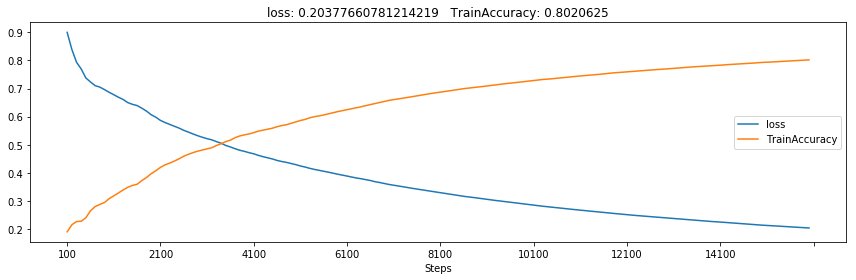

Epoch [10/10], Step [16000], Train_Loss: 0.2038, Train_Accuracy: 0.8021
Epoch [10/10], Step [16001], Train_Loss: 0.2038, Train_Accuracy: 0.8021
Epoch [10/10], Step [16002], Train_Loss: 0.2038, Train_Accuracy: 0.8021
Epoch [10/10], Step [16003], Train_Loss: 0.2037, Train_Accuracy: 0.8021
Epoch [10/10], Step [16004], Train_Loss: 0.2037, Train_Accuracy: 0.8021
Epoch [10/10], Step [16005], Train_Loss: 0.2037, Train_Accuracy: 0.8021
Epoch [10/10], Step [16006], Train_Loss: 0.2037, Train_Accuracy: 0.8021
Epoch [10/10], Step [16007], Train_Loss: 0.2037, Train_Accuracy: 0.8021
Epoch [10/10], Step [16008], Train_Loss: 0.2037, Train_Accuracy: 0.8022
Epoch [10/10], Step [16009], Train_Loss: 0.2037, Train_Accuracy: 0.8022
Epoch [10/10], Step [16010], Train_Loss: 0.2037, Train_Accuracy: 0.8022
Epoch [10/10], Step [16011], Train_Loss: 0.2037, Train_Accuracy: 0.8022
Epoch [10/10], Step [16012], Train_Loss: 0.2036, Train_Accuracy: 0.8022
Epoch [10/10], Step [16013], Train_Loss: 0.2036, Train_Accuracy:

In [8]:
train_model(model, train_data)

# Test Model

In [9]:
test_model(model, test_data)

100%|██████████| 402/402 [00:36<00:00, 10.87it/s]

Test Acc: 72.89 %


# Save Model

In [ ]:
save_model(model, "QA_model.ckpt")